**Introduction**

The concept of Long Short Term Memory networks were first envisioned by Sepp Hochreiter and Jürgen Schmidhuber in 1997 which provided a huge advancement within the world of Reccurent Neural Networks. LSTMs utilize gates which learn to pass on certain parts of a given input to be utilized when determining an output. 


Quora is a website which hosts an online platform where questions can be asked and then be asnwered by the online community. The the community intends to answer questions posed by curious individuals from topics ranging from relgion to technology. A majority of the answers provided are well intedned, but infrequently, insencere responses are posted which provide no value to the question asked. If Quora is capable of identifying these types of responses, it can make sure it's community is a benefical environment for all users. The following analysis intends to identify inscencere questions that have been posted within the Quora Community by utilizing Convolutional Networks in tangent with LSTMs. 


Below, we import the required modules for the analysis.

In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math

from sklearn.metrics import roc_curve, auc,  f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import keras
from sklearn import metrics
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, BatchNormalization, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D,CuDNNLSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, GlobalMaxPool1D, TimeDistributed
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


**Preproccessing**

The train data set consists of 1.31 million records for the training data where the commentary is preclassified as toxic or non toxic. The test data set consists of 376 thousand records.

In order for computers to be able to process english text, they must convert the sentences to vectors. We will first tokenize the sentences where each word is given a value. Each sentence must be the same length before entering the neural network which is why we utilize the pad_sequences function. 

We will now read in the data and split it into train and test, tokenize the comments, and pad the comments for preprocessing.

In [2]:
#filename = '../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin.gz'
#model = KeyedVectors.load_word2vec_format(filename, binary=True)
df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=2018)
train_df, val_df = train_test_split(train_df, test_size=0.34, random_state=2018)

## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values
test_y = test_df['target'].values

**Embedding**

It takes years for humans to comprehend the intriciacies of a language such as grammer, future and past tenses, and parts of speech. Though we could input our data into the Neural Netowrk immdeitaly, we can utilize anexternal dictionary which seek to expalin what each word utilized with our data set means. 

A glove embedding is an unsupervised algorithm which aims to produce vectors that represent all words within a given corpra. A glove is initiated by creating a matrix sized by the (unique number of words) x (unique number of words). The values within the matrix are indicative of how often a word is associated with another word. The matrix is then factorized to yield lower dimesnionality to produce a matrix (words) x (# of desired features). Though these features don't have a specific meaning, the more features produced, the more differentiation can be created between words. 

The glove embedding utilized within this analysis was created by Standford by training on the corpra of Wikipedia2014 which contains 400k unique words within it's corpra. A function is created below to find the embeedings within the quora corpra data set utlizing standford's glove embeddings. 

In [3]:
EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


We will now constrct the Neural Networks which utilizes both Convolutional Neural Networks and Recurrent Neural Networks in Keras. 

1. The comments within the train data set must first be translated into numerical embeddings utilizing Stanford's glove embedding.

2. A 2 dimensional CNN is then used across the comments with the filter sizes set at the top.
    
    A. The first dimension looks at the number of words to utilize when learning to determine the classification of our output.
        
        a. The first filter size of 1 looks strictly at the word to determine the output.
        
        b. The next 4 filters look at the word and the words following it to determine the output. The   
        filter allows the Conv2D to look at the next word, 2 words, 3 words, and 4 words respectively to 
        determine the classification of the given data.  
        
    B. The second dimension looks at the word embeddings of each of the words within our filter, which again consist of 300 vectors.
    
3. A Bidirectional LSTM is then utilized to determine the output.

    A.The Bidirectional layer creates two LSTMs where one LSTM reads a comment from left to right and the other utilizes the other LSTM to read the comment from right to left. These LSTMs are used in tandem to determine the classification of the comment. 
    
4. A simple layer of 100 neurons are then used before a final dense layer which will produce the perdicted classification of the comment.


In [4]:
filter_sizes = [1,2,3,5]
num_filters = 128

inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Reshape((maxlen, embed_size, 1))(x)

maxpool_pool = []
for i in range(len(filter_sizes)):
    conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                 kernel_initializer='glorot_uniform', activation='relu')(x) 
    maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

z = Concatenate(axis=1)(maxpool_pool) 
z = TimeDistributed(Bidirectional(CuDNNLSTM(256)))(z)
z = BatchNormalization()(z)
z = Flatten()(z)
z = Dense(100, activation="relu")(z)
z = Dropout(.5)(z)
z = Dense(100, activation="relu")(z)
z = Dropout(.5)(z)
z = Dense(10, activation="relu")(z)

outp = Dense(1, activation="sigmoid")(z)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     15000000    input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)    

We will fit the model below.

In [5]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint
#earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(train_X, train_y, batch_size=512, epochs=3, validation_data=(val_X, val_y))

Instructions for updating:
Use tf.cast instead.
Train on 689632 samples, validate on 355265 samples
Epoch 1/3
689632/689632 [==============================] - 103s 150us/step - loss: 0.1220 - acc: 0.9519 - val_loss: 0.1567 - val_acc: 0.9574
Epoch 2/3
689632/689632 [==============================] - 97s 140us/step - loss: 0.0976 - acc: 0.9612 - val_loss: 0.1128 - val_acc: 0.9583
Epoch 3/3
689632/689632 [==============================] - 97s 141us/step - loss: 0.0821 - acc: 0.9667 - val_loss: 0.1111 - val_acc: 0.9581


The two visualizations below look at our train and validation acurracy and the binary crossentropy loss of the binary model. It is clear that the model begins to overfit our training data after the first epoch, so we'll rerun our fit with only 1 epoch.  

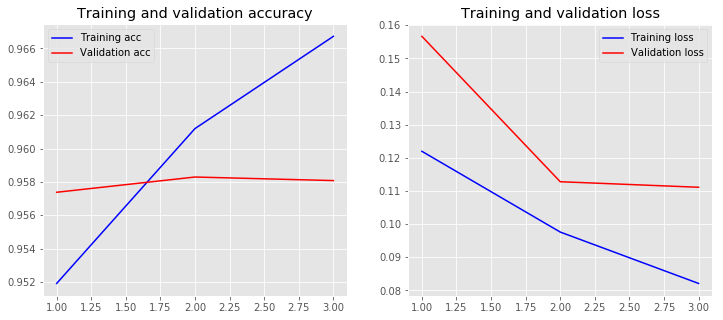

In [6]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

def plot_history(history):
    acc = history.history["acc"]
    val_acc = history.history["val_acc"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training acc")
    plt.plot(x, val_acc, "r", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    
plot_history(history=history)

In [7]:
history = model.fit(train_X, train_y, batch_size=512, epochs=1, validation_data=(val_X, val_y))

Train on 689632 samples, validate on 355265 samples
Epoch 1/1
689632/689632 [==============================] - 97s 140us/step - loss: 0.0649 - acc: 0.9734 - val_loss: 0.1204 - val_acc: 0.9551


In [8]:
y_pred = model.predict(test_X)

In [9]:
fpr, tpr, thresholds =roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.952337


With our final layer utlizing a sigmoid as it's activation function, the neural network will produce a value between 0 and 1. We can take a standard cutoff point of .5 which produces an f1 score below of .654 which would put this f1 score at the top 20th percentile of all submissions for this Kaggle competition.  

In [10]:
y_pred1 = np.where(y_pred > .5, 1, 0)
print("F1 score is equivalent to {}".format(f1_score(test_y,y_pred1)))

F1 score is equivalent to 0.6453470930581389


In [11]:
from sklearn.metrics import classification_report
print(classification_report(test_y,y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    245029
           1       0.63      0.66      0.65     16196

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.80      0.82      0.81    261225
weighted avg       0.96      0.95      0.96    261225



The model does quite a good job at corecctly classifiyin non-toxic comments with a precision of .98 and a recall of .97. What the model doesn't excel in is in classifying the toxic comments with a precision of .63 and a recall of .68. The business value for this model is to allow someone to manual check the predicted toxic comments and decide where they need to be removed from the forum. With a recall of .68, the model will only capture 68% of the truly toxic comments. We can increase this percentage by lowering the cutoff point for the model when considering if a comment is toxic.

We will lower the cutoff to .3. This will lower precision to .4 and recall will rise to .9. This means that out of all the comments the model predicted as toxic, 90% of the true toxic comments population will be captured. The cost for this is that only 40% of the comments our model predicted to be toxic will truly be toxic. A user will then have to manually identify the truly toxic comments from the predicted toxic comments because 60% of the predicted toxic comments are not toxic.

In [12]:
y_pred1 = np.where(y_pred > .3, 1, 0)
from sklearn.metrics import classification_report
print(classification_report(test_y,y_pred1))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    245029
           1       0.49      0.81      0.62     16196

   micro avg       0.94      0.94      0.94    261225
   macro avg       0.74      0.88      0.79    261225
weighted avg       0.96      0.94      0.94    261225



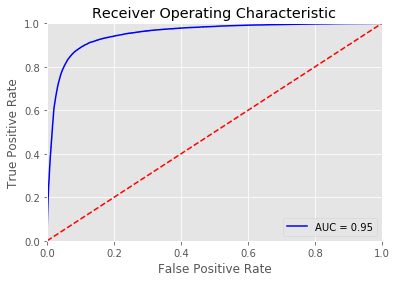

In [13]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()